<font size="6"> **DMBEM Project**</font>


Lena Beber, Charles Gerike-Roberts, Elliot Regev

# Description of the Building

The building we tried to model is a two story house in England (Fig. 1). It is made out of concrete walls with a layer of insulation, has a suspended floor, a slanted roof with clay tiles and insulation and double glazed windows on every wall. 

# Hypothesis for Modelling

For our model we had to simplify the building described above. We assume that we can neglect the walls separating the rooms and even the floor inbetween the two stories, because of the equal temperature in every room. Instead we model just one large room. We also assume that all the windows of a wall can be modeled as one large window on that wall. 

# Thermal Network Model

# Equations (Matrices and Vectors)


## Thermal Circuit 0: Indoor Air

$ \color{grey}{ A_0= \left(\begin{array}{cc} 
1 & -1 & 0 & 0 & 0 & 0 & 0\\
1 & 0 & -1 & 0 & 0 & 0 & 0\\
1 & 0 & 0 & -1 & 0 & 0 & 0\\
1 & 0 & 0 & 0 & -1 & 0 & 0\\
1 & 0 & 0 & 0 & 0 & -1 & 0\\
1 & 0 & 0 & 0 & 0 & 0 & -1
\end{array}\right)
}$

$ \color{grey}{ G_0=\text{diag} \left(\begin{array}{cc} 
G_{in, wall_1} & G_{in, wall_2} & G_{in, wall_3} & G_{in, glass} & G_{in, roof_{north}} & G_{in, roof_{south}} & G_{in, floor}
\end{array}\right)^T
}$

$ \color{grey}{ b_0= \left(\begin{array}{cc} 
0 & 0 & 0 & 0 & 0 & 0 & 0
\end{array}\right)^T
}$

$ \color{grey}{ C_0=\text{diag} \left(\begin{array}{cc} 
C_{air}/2 & 0 & 0 & 0 & 0 & 0
\end{array}\right)^T
}$

$ \color{grey}{ f_0= \left(\begin{array}{cc} 
0 & 0 & 0 & 0 & 0 & 1
\end{array}\right)^T
}$

## Thermal Circuit 1: Ventilation

$ \color{purple}{ A_1= \left(\begin{array}{cc} 
1\\
1
\end{array}\right)
}$

$ \color{purple}{ G_1=\text{diag} \left(\begin{array}{cc} 
G_{ventilation} & Kp_{f/c/h}
\end{array}\right)^T
}$

$ \color{purple}{ b_1= \left(\begin{array}{cc} 
1 & 1
\end{array}\right)^T
}$

$ \color{purple}{ C_1=\text{diag} \left(\begin{array}{cc} 
C_{air}/2
\end{array}\right)^T
}$

$ \color{purple}{ f_1= \left(\begin{array}{cc} 
1
\end{array}\right)^T
}$

## Thermal Circuit 2, 3 and 4: Solid Walls

$ \color{red}{ A_{2,3,4}= \left(\begin{array}{cc} 
1 & 0 & 0 & 0 & 0\\
-1 & 1 & 0 & 0 & 0\\
0 & -1 & 1 & 0 & 0\\
0 & 0 & -1 & 1 & 0\\
0 & 0 & 0 & -1 & 1
\end{array}\right)
}$

$ \color{red}{ G_{2,3,4}=\text{diag} \left(\begin{array}{cc} 
G_{out, wall} & 2G_c & 2G_c & 2G_i &2G_i
\end{array}\right)^T
}$

$ \color{red}{ b_{2,3,4}= \left(\begin{array}{cc} 
1 & 0 & 0 & 0 & 0
\end{array}\right)^T
}$

$ \color{red}{ C_{2,3,4}=\text{diag} \left(\begin{array}{cc} 
0 & C_c & 0 & C_i & 0
\end{array}\right)^T
}$

$ \color{red}{ f_{2,3,4}= \left(\begin{array}{cc} 
1 & 0 & 0 & 0 & 1
\end{array}\right)^T
}$

## Thermal Circuit 5: Windows (Glass)

$ \color{green}{ A_5= \left(\begin{array}{cc} 
1 & 0\\
-1 & 1
\end{array}\right)
}$

$ \color{green}{ G_5=\text{diag} \left(\begin{array}{cc} 
G_{out, glass} & 2G_g
\end{array}\right)^T
}$

$ \color{green}{ b_5= \left(\begin{array}{cc} 
1 & 0
\end{array}\right)^T
}$

$ \color{green}{ C_5=\text{diag} \left(\begin{array}{cc} 
C_g & 0
\end{array}\right)^T
}$

$ \color{green}{ f_5= \left(\begin{array}{cc} 
1 & 0
\end{array}\right)^T
}$

## Thermal Circuit 6 and 7: Roof

$ \color{orange}{ A_{6,7}= \left(\begin{array}{cc} 
-1 & 0 & 0\\
-1 & 1 & 0\\
0 & -1 & 1
\end{array}\right)
}$

$ \color{orange}{ G_{6,7}=\text{diag} \left(\begin{array}{cc} 
G_{out, roof_{north/south}} & 2G_i & 2G_i
\end{array}\right)^T
}$

$ \color{orange}{ b_{6,7}= \left(\begin{array}{cc} 
1 & 0 & 0
\end{array}\right)^T
}$

$ \color{orange}{ C_{6,7}=\text{diag} \left(\begin{array}{cc} 
0 & C_i & 0
\end{array}\right)^T
}$

$ \color{orange}{ f_{6,7}= \left(\begin{array}{cc} 
1 & 0 & 1
\end{array}\right)^T
}$

## Thermal Circuit 8: Floor

$ \color{blue}{ A_8= \left(\begin{array}{cc} 
1 & 0 & 0 & 0 & 0\\
-1 & 1 & 0 & 0 & 0\\
0 & -1 & 1 & 0 & 0\\
0 & 0 & -1 & 1 & 0\\
0 & 0 & 0 & -1 & 1
\end{array}\right)
}$

$ \color{blue}{ G_8=\text{diag} \left(\begin{array}{cc} 
G_{in, floor} & G_{in, floor} & G_{in, floor} & 2G_{wood} & 2G_{wood}
\end{array}\right)^T
}$

$ \color{blue}{ b_8= \left(\begin{array}{cc} 
1 & 0 & 0 & 0 & 0
\end{array}\right)^T
}$

$ \color{blue}{ C_8=\text{diag} \left(\begin{array}{cc} 
0 & C_{air} & 0 & C_{wood} & 0
\end{array}\right)^T
}$

$ \color{blue}{ f_8= \left(\begin{array}{cc} 
0 & 0 & 0 & 0 & 1
\end{array}\right)^T
}$

## Assembly Matrix

$ Ass= \left(\begin{array}{cc} 
\color{purple}{1} & \color{purple}{0} & \color{grey}{0} & \color{grey}{0}\\
\color{red}{2} & \color{red}{4} & \color{grey}{1} & \color{grey}{0}\\
\color{red}{3} & \color{red}{4} & \color{grey}{2} & \color{grey}{0}\\
\color{red}{4} & \color{red}{4} & \color{grey}{3} & \color{grey}{0}\\
\color{green}{5} & \color{green}{1} & \color{grey}{4} & \color{grey}{0}\\
\color{orange}{6} & \color{orange}{2} & \color{grey}{5} & \color{grey}{0}\\
\color{orange}{7} & \color{orange}{2} & \color{grey}{6} & \color{grey}{0}\\
\color{blue}{8} & \color{blue}{4} & \color{grey}{7} & \color{grey}{0}
\end{array}\right)
$


# Python Implementation

We decided to restructure the given code to make it more flexible. Our concept was two have one "main" python file that calls various functions for the different steps of the modelling. The structure of our code is depicted in the graphic below.

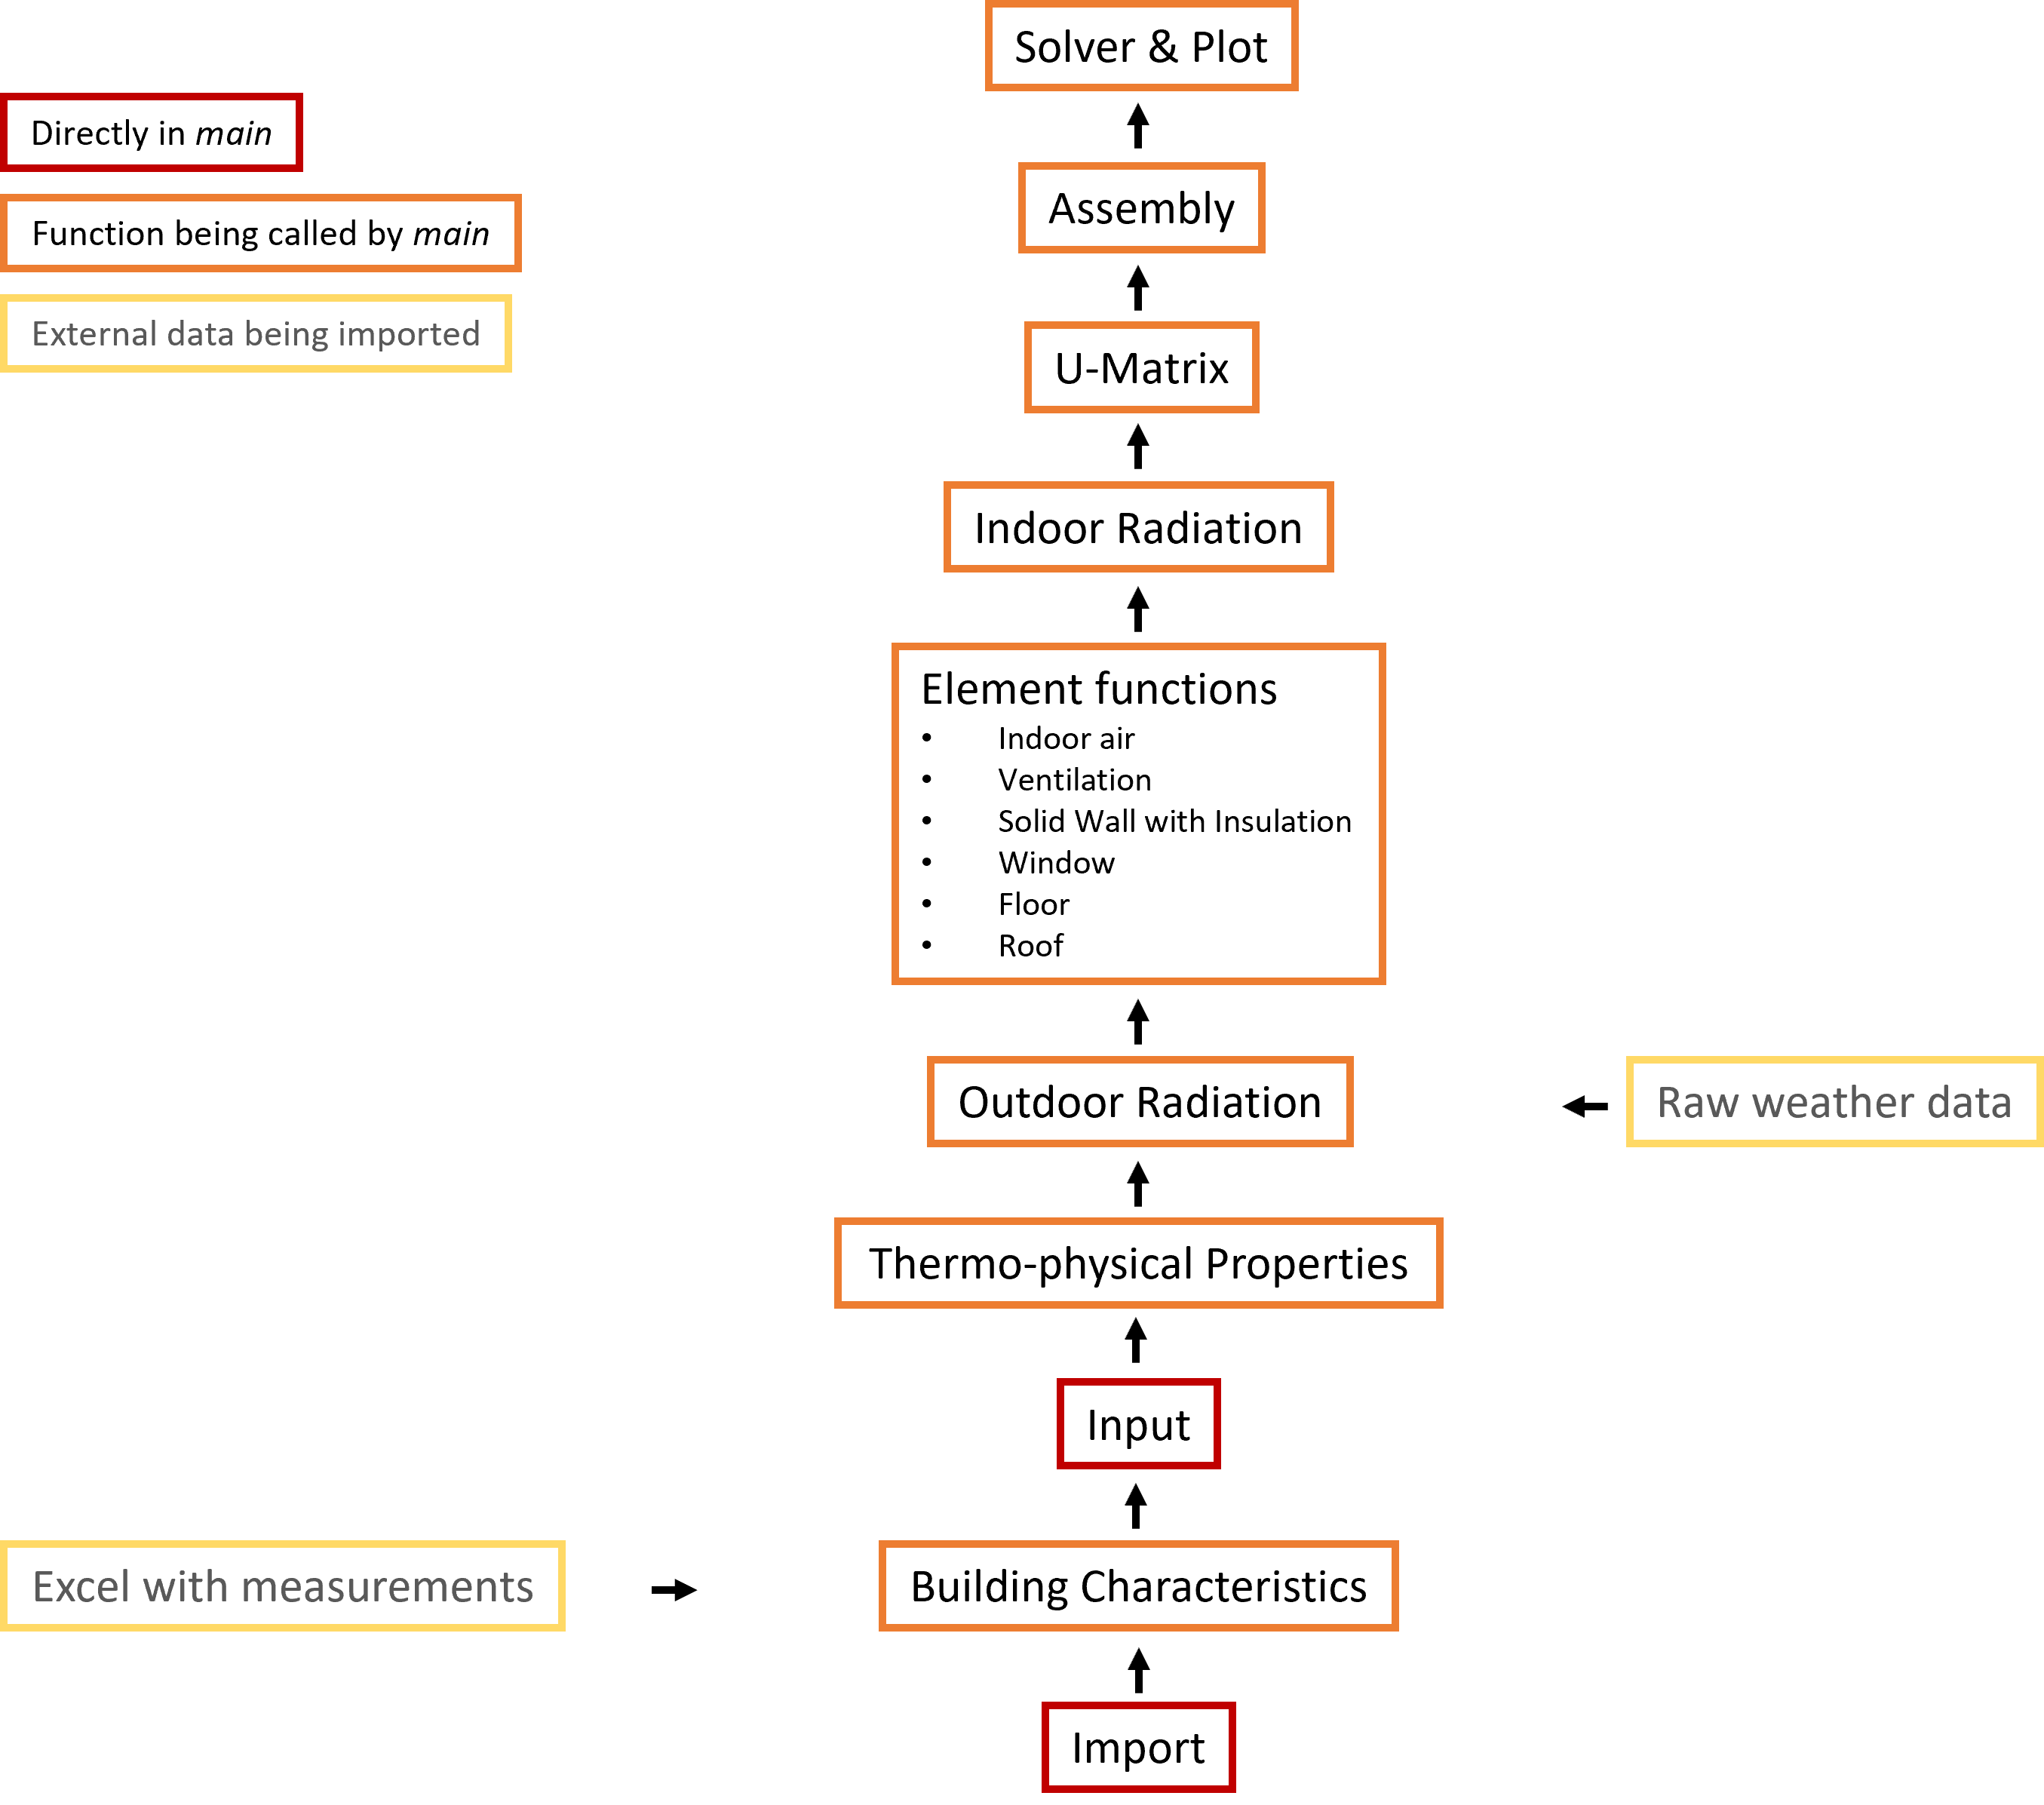

## Import
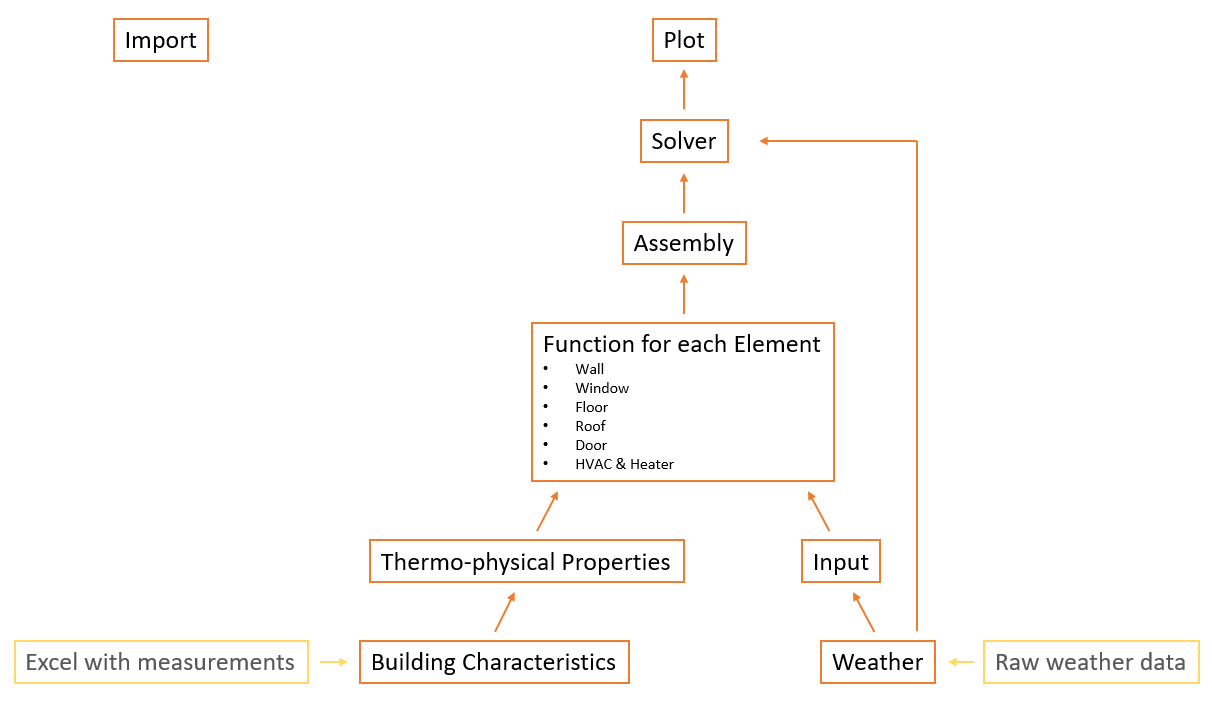

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import TCM_funcs
import dm4bem

# global constants
σ = 5.67e-8     # W/m².K⁴ Stefan-Bolzmann constant

## Building Characteristics

This function is designed to read a csv file which contains the characteristics of the building and create a data frame from it.

In [ ]:
def building_characteristics():

    bc = pd.read_csv(r'Building Characteristics.csv', na_values=["N"], keep_default_na=True)

    return bc

This function is the first to be called in the main file:

In [ ]:
# Define building characteristics
bc = TCM_funcs.building_characteristics()

print(bc)

As one can see, this data frame consists of different elements that can each be modelled as one thermal circuit. For every element the materials that are part of this element are specified as well as dimensions for the whole element and for the single materials.

Properties specified for each element:
- Element Code
- Element Type
- Material 1, 2 and 3
- Length
- Width
- Height
- Thickness of each Material
- Surface Area
- Volume
- Slope
- Azimuth
- Mesh for each Material



## Input 

After this changeable input variables are defined in the main file:

In [ ]:
# Define Inputs
Kpc = 500                                                  # Kp factor for free cooling
Kpf = 1e-3                                                 # Kp factor for cooling
Kph = 1e4                                                  # Kp factor for HVAC
dt = 5                                                     # s - time step for solver
T_set = pd.DataFrame([{'cooling': 26, 'heating': 20}])     # C - temperature set points
Tm = 20 + 273.15                                           # K - Mean temperature for radiative exchange
ACH = 1                                                    # h*-1 - no. of air changes in volume per hour
h = pd.DataFrame([{'in': 4., 'out': 10}])                  # W/m² K - convection coefficients
V = bc.Volume[4]                                           # m³
Vdot = V * ACH / 3600                                      # m³/s - volume flow rate due to air changes
albedo_sur = 0.2                                           # albedo for the surroundings
latitude = 45
Qa = 0                                                     # auxiliary heat flow
Tisp = 20                                                  # Initial conditions Temperature
DeltaT = 5                                                 # Temperature difference before active cooling is activated
DeltaBlind = 2                                             # Temperature difference before the blinds close
WF = 'GBR_ENG_RAF.Lyneham.037400_TMYx.2004-2018.epw'       # Name of the weather data file
t_start = '2000-01-03 12:00:00'
t_end = '2000-01-04 18:00:00'


## Thermo-physical Properties

In this function first a data frame containing thermo-physical properties for various materials is created. As an input variable the bc data frame is given into the function and is being extended by the thermo-physical properties of the according to the specified materials per element. This extended version of the bc data frame (now called bcp, "Building Characteristics with thermo physical Properties") is being returned to the main. 

Materials currently present in the thermal properties data frame:
- concrete
- insulation
- glass
- air
- tiles
- wood

Properties listed for each of materials above:
- density kg/m³
- specific heat J/kg.K
- conductivity W/m.K
- long wave emissivity
- short wave transmittance
- absorptivity
- albedo

The values for these properties were taken from Incropera et al. (2011) Fundamentals of heat and mass transfer, 7 ed, Table A3, and the Engineering Toolbox (https://www.engineeringtoolbox.com, 30. October 2021).


In [ ]:
def thphprop(BCdf):
    thphp = {'Material': ['Concrete', 'Insulation', 'Glass', 'Air', 'Tile', 'Wood'],
             'Density': [2300, 55, 2500, 1.2, None, 720],  # kg/m³
             'Specific_Heat': [880, 1210, 750, 1000, None, 1255],  # J/kg.K
             'Conductivity': [1.4, 0.027, 1.4, None, 0.52, 0.16],  # W/m.K
             'LW_Emissivity': [0.9, 0, 0.9, 0, 0.91, 0.885],
             'SW_Transmittance': [0, 0, 0.83, 1, 0, 0],
             'SW_Absorptivity': [0.25, 0.25, 0.1, 0, 0.64, 0.6],
             'Albedo': [0.75, 0.75, 0.07, 0, 0.36, 0.4]}  # albedo + SW transmission + SW absorptivity = 1

    thphp = pd.DataFrame(thphp)

    # add empty columns for thermo-physical properties
    BCdf = BCdf.reindex(columns=BCdf.columns.to_list() + ['rad_s', 'density_1', 'specific_heat_1', 'conductivity_1',
                                                          'LW_emissivity_1', 'SW_transmittance_1', 'SW_absorptivity_1',
                                                          'albedo_1', 'density_2', 'specific_heat_2', 'conductivity_2',
                                                          'LW_emissivity_2', 'SW_transmittance_2', 'SW_absorptivity_2',
                                                          'albedo_2', 'density_3', 'specific_heat_3', 'conductivity_3',
                                                          'LW_emissivity_3', 'SW_transmittance_3', 'SW_absorptivity_3',
                                                          'albedo_3'])

    # fill columns with properties for the given materials 1-3 of each element
    for i in range(0, len(BCdf)):
        for j in range(0, len(thphp['Material'])):
            if BCdf.loc[i, 'Material_1'] == thphp.Material[j]:
                BCdf.loc[i, 'density_1'] = thphp.Density[j]
                BCdf.loc[i, 'specific_heat_1'] = thphp.Specific_Heat[j]
                BCdf.loc[i, 'conductivity_1'] = thphp.Conductivity[j]
                BCdf.loc[i, 'LW_emissivity_1'] = thphp.LW_Emissivity[j]
                BCdf.loc[i, 'SW_transmittance_1'] = thphp.SW_Transmittance[j]
                BCdf.loc[i, 'SW_absorptivity_1'] = thphp.SW_Absorptivity[j]
                BCdf.loc[i, 'albedo_1'] = thphp.Albedo[j]

        for j in range(0, len(thphp['Material'])):
            if BCdf.loc[i, 'Material_2'] == thphp.Material[j]:
                BCdf.loc[i, 'density_2'] = thphp.Density[j]
                BCdf.loc[i, 'specific_heat_2'] = thphp.Specific_Heat[j]
                BCdf.loc[i, 'conductivity_2'] = thphp.Conductivity[j]
                BCdf.loc[i, 'LW_emissivity_2'] = thphp.LW_Emissivity[j]
                BCdf.loc[i, 'SW_transmittance_2'] = thphp.SW_Transmittance[j]
                BCdf.loc[i, 'SW_absorptivity_2'] = thphp.SW_Absorptivity[j]
                BCdf.loc[i, 'albedo_2'] = thphp.Albedo[j]

        for j in range(0, len(thphp['Material'])):
            if BCdf.loc[i, 'Material_3'] == thphp.Material[j]:
                BCdf.loc[i, 'density_3'] = thphp.Density[j]
                BCdf.loc[i, 'specific_heat_3'] = thphp.Specific_Heat[j]
                BCdf.loc[i, 'conductivity_3'] = thphp.Conductivity[j]
                BCdf.loc[i, 'LW_emissivity_3'] = thphp.LW_Emissivity[j]
                BCdf.loc[i, 'SW_transmittance_3'] = thphp.SW_Transmittance[j]
                BCdf.loc[i, 'SW_absorptivity_3'] = thphp.SW_Absorptivity[j]
                BCdf.loc[i, 'albedo_3'] = thphp.Albedo[j]

    return BCdf

This function is second to be called in the main:

In [ ]:
bcp = TCM_funcs.thphprop(bc)

## Outdoor Radiation

Next we calculate the radiation hitting the building from outside, taking the different exposures into account using the following function:

In [ ]:
def rad(bcp, albedo_sur, latitude, dt, WF, t_start, t_end):
    # Simulation with weather data
    # ----------------------------
    filename = WF
    start_date = t_start
    end_date = t_end

    # Read weather data from Energyplus .epw file
    [data, meta] = dm4bem.read_epw(filename, coerce_year=None)
    weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
    del data
    weather.index = weather.index.map(lambda t: t.replace(year=2000))
    weather = weather[(weather.index >= start_date) & (
            weather.index < end_date)]
    # Solar radiation on a tilted surface South
    Φt = {}
    for k in range(0, len(bcp)):
        surface_orientationS = {'slope': bcp.loc[k, 'Slope'],
                                'azimuth': bcp.loc[k, 'Azimuth'],
                                'latitude': latitude}
        rad_surf = dm4bem.sol_rad_tilt_surf(weather, surface_orientationS, albedo_sur)
        Φt.update({str(k + 2): rad_surf.sum(axis=1)})

    Φt = pd.DataFrame(Φt)
    # Interpolate weather data for time step dt
    data = pd.concat([weather['temp_air'], Φt], axis=1)
    data = data.resample(str(dt) + 'S').interpolate(method='linear')
    data = data.rename(columns={'temp_air': 'To'})

    # time
    t = dt * np.arange(data.shape[0])

    return data, t


This is called in the main:

In [ ]:
# Determine solar radiation for each element
rad_surf_tot, t = TCM_funcs.rad(bcp, albedo_sur, latitude, dt, WF, t_start, t_end)

## Element Functions

As a next step the Matrices for every single element are being created and stored in a data frame. As of now there are functions for six different elements:

- Indoor Air
- Ventilation (HVAC)
- Solid Wall with Insulation
- Window (single glazing)
- Floor
- Roof (flat)

Depending on the element there are diffierent variables needed to create the matrices, so the input for every element function is a different one. The input is described in the beginning of each function. All of the element functions return a dictionary containing the matrices describing that element.

In [ ]:
def indoor_air(bcp_sur, h, V, Qa, rad_surf_tot):
    """
    Input:
    bcp_sur, surface column of bcp dataframe
    h, convection dataframe
    V, Volume of the room (from bcp)
    Output: TCd, a dictionary of the all the matrices of the thermal circuit of the inside air
    """
    nt = len(bcp_sur) + 1
    nq = len(bcp_sur)

    nq_ones = np.ones(nq)
    A = np.diag(-nq_ones)
    A = np.c_[nq_ones, A]

    G = np.zeros(nq)
    for i in range(0, len(G)):
        G[i] = h['in'] * bcp_sur[i]
    G = np.diag(G)
    b = np.zeros(nq)
    C = np.zeros(nt)
    C[-1] = (1.2 * 1000 * V) / 2  # Capacity air = Density*specific heat*V
    C = np.diag(C)
    f = np.zeros(nt)
    f[-1] = 1
    y = np.zeros(nt)
    y[-1] = 1
    Q = np.zeros((rad_surf_tot.shape[0], nt))
    Q[0] = Qa
    Q[:, 1:nt] = 'NaN'
    T = np.zeros((rad_surf_tot.shape[0], nq))
    T[:, 0:nq] = 'NaN'

    TCd = {'A': A, 'G': G, 'b': b, 'C': C, 'f': f, 'y': y, 'Q': Q, 'T': T}

    return TCd


def ventilation(V, V_dot, Kp, T_set, rad_surf_tot):
    """
    Input:
    V, Volume of the room (from bcp)
    V_dot
    Kp
    Output:
    TCd, a dictionary of the all the matrices describing the thermal circuit of the ventilation
    """
    Gv = V_dot * 1.2 * 1000  # Va_dot * air['Density'] * air['Specific heat']
    A = np.array([[1],
                  [1]])
    G = np.diag(np.hstack([Gv, Kp]))
    b = np.array([1, 1])
    C = np.array((1.2 * 1000 * V) / 2)
    f = 1
    y = 1
    Q = np.zeros((rad_surf_tot.shape[0], 1))
    Q[:, :] = 'NaN'
    T = np.zeros((rad_surf_tot.shape[0], 2))
    T[:, 0] = rad_surf_tot['To']
    T[:, 1] = T_set['heating']

    TCd = {'A': A, 'G': G, 'b': b, 'C': C, 'f': f, 'y': y, 'Q': Q, 'T': T}

    return TCd


def solid_wall_w_ins(bcp_r, h, rad_surf_tot, uc):
    """Input:
    bcp_r, one row of the bcp dataframe
    h, convection dataframe
    Output: TCd, a dictionary of the all the matrices of one thermal circuit describing a solid wall with insulation
    """
    # Thermal conductances
    # Conduction
    G_cd_cm = bcp_r['conductivity_1'] / bcp_r['Thickness_1'] * bcp_r['Surface']  # concrete
    G_cd_in = bcp_r['conductivity_2'] / bcp_r['Thickness_2'] * bcp_r['Surface']  # insulation

    # Convection
    Gw = h * bcp_r['Surface']  # wall

    # Thermal capacities
    Capacity_cm = bcp_r['density_1'] * bcp_r['specific_heat_1'] * bcp_r['Surface'] * bcp_r['Thickness_1']
    Capacity_in = bcp_r['density_2'] * bcp_r['specific_heat_2'] * bcp_r['Surface'] * bcp_r['Thickness_2']

    # Thermal network
    # ---------------
    nq = 1 + 2 * (int(bcp_r['Mesh_1']) + int(bcp_r['Mesh_2']))
    nt = 1 + 2 * (int(bcp_r['Mesh_1']) + int(bcp_r['Mesh_2']))

    A = np.eye(nq + 1, nt)
    A = -np.diff(A, 1, 0).T

    nc = int(bcp_r['Mesh_1'])
    ni = int(bcp_r['Mesh_2'])
    Gcm = 2 * nc * G_cd_cm
    Gcm = 2 * nc * np.array(Gcm)
    Gim = 2 * ni * G_cd_in
    Gim = 2 * ni * np.array(Gim)
    G = np.diag(np.hstack([Gw['out'], Gcm, Gim]))

    b = np.zeros(nq)
    b[0] = 1

    Ccm = Capacity_cm / nc * np.mod(range(0, 2 * nc), 2)
    Cim = Capacity_in / ni * np.mod(range(0, 2 * ni), 2)
    C = np.diag(np.hstack([Ccm, Cim, 0]))

    f = np.zeros(nt)
    f[0] = f[-1] = 1

    y = np.zeros(nt)

    Q = np.zeros((rad_surf_tot.shape[0], nt))
    Q[:, 0] = bcp_r['SW_absorptivity_1'] * bcp_r['Surface'] * rad_surf_tot[str(uc)]
    Q[:, (nt - 1)] = -1
    uca = uc + 1
    Q[:, 1:(nt - 1)] = 'NaN'

    T = np.zeros((rad_surf_tot.shape[0], nq))
    T[:, 0] = rad_surf_tot['To']
    T[:, 1:nq] = 'NaN'

    TCd = {'A': A, 'G': G, 'b': b, 'C': C, 'f': f, 'y': y, 'Q': Q, 'T': T}

    return TCd, uca


def window(bcp_r, h, rad_surf_tot, uc):
    """Input:
    bcp_r, one row of the bcp dataframe
    h, convection dataframe
    Output: TCd, a dictionary of the all the matrices of one thermal circuit describing a solid wall with insulation
    """
    nq = 2 * (int(bcp_r['Mesh_1']))
    nt = 2 * (int(bcp_r['Mesh_1']))

    A = np.array([[1, 0],
                  [-1, 1]])
    Ggo = h['out'] * bcp_r['Surface']
    Ggs = 1 / (1 / Ggo + 1 / (2 * bcp_r['conductivity_1']))
    G = np.diag(np.hstack([Ggs, 2 * bcp_r['conductivity_1']]))
    b = np.array([1, 0])
    C = np.diag([bcp_r['density_1'] * bcp_r['specific_heat_1'] * bcp_r['Surface'] * bcp_r['Thickness_1'], 0])
    f = np.array([1, 0])
    y = np.array([0, 0])

    Q = np.zeros((rad_surf_tot.shape[0], nt))
    IG_surface = bcp_r['Surface'] * rad_surf_tot[str(uc)]
    IGR = bcp_r['SW_transmittance_1'] * bcp_r['Surface'] * rad_surf_tot[str(uc)]
    Q[:, 0] = bcp_r['SW_absorptivity_1'] * IG_surface
    uca = uc + 1
    Q[:, 1:nt] = 'NaN'

    T = np.zeros((rad_surf_tot.shape[0], nq))
    T[:, 0] = rad_surf_tot['To']
    T[:, 1:nq] = 'NaN'

    TCd = {'A': A, 'G': G, 'b': b, 'C': C, 'f': f, 'y': y, 'Q': Q, 'T': T}

    return TCd, uca, IGR


def susp_floor(bcp_r, h, V, rad_surf_tot, uc):
    """Input:
    bcp_r, one row of the bcp dataframe
    h, convection dataframe
    V, Volume of the room from bcp
    Output: TCd, a dictionary of the all the matrices of one thermal circuit describing a suspended floor
    """
    nq = 2 * (int(bcp_r['Mesh_1']) + int(bcp_r['Mesh_2']))
    nt = 2 * (int(bcp_r['Mesh_1']) + int(bcp_r['Mesh_2']))

    A = np.array([[1, 0, 0, 0],
                  [-1, 1, 0, 0],
                  [0, -1, 1, 0],
                  [0, 0, -1, 1]])
    Gw = h * bcp_r['Surface']
    G_cd = bcp_r['conductivity_1'] / bcp_r['Thickness_1'] * bcp_r['Surface']  # wood
    G = np.diag(np.hstack(
        [Gw['in'], Gw['in'], G_cd, G_cd]))
    b = np.array([1, 0, 0, 0])
    Capacity_w = bcp_r['density_1'] * bcp_r['specific_heat_1'] * bcp_r['Surface'] * bcp_r['Thickness_1']  # wood
    Capacity_a = bcp_r['density_2'] * bcp_r['specific_heat_2'] * V  # air
    C = np.diag([Capacity_a, 0, Capacity_w, 0])
    f = np.array([0, 0, 0, 1])
    y = np.array([0, 0, 0, 0])

    Q = np.zeros((rad_surf_tot.shape[0], nt))
    Q[:, 0] = bcp_r['SW_absorptivity_1'] * bcp_r['Surface'] * rad_surf_tot[str(uc)]
    Q[:, (nt - 1)] = -1
    uca = uc + 1
    Q[:, 1:(nt - 1)] = 'NaN'

    T = np.zeros((rad_surf_tot.shape[0], nq))
    T[:, 0] = rad_surf_tot['To']
    T[:, 1:nq] = 'NaN'

    TCd = {'A': A, 'G': G, 'b': b, 'C': C, 'f': f, 'y': y, 'Q': Q, 'T': T}

    return TCd, uca


def flat_roof_w_in(bcp_r, h, rad_surf_tot, uc):
    """Input:
    bcp_r, one row of the bcp dataframe
    h, convection dataframe
    Output: TCd, a dictionary of the all the matrices of one thermal circuit describing a flat roof with insulation
    """
    nq = 2 * (int(bcp_r['Mesh_1']))
    nt = 2 * (int(bcp_r['Mesh_1']))

    A = np.array([[-1, 0, 0],
                  [-1, 1, 0],
                  [0, -1, 1]])
    Gw = h * bcp_r['Surface']
    G_cd_in = bcp_r['conductivity_2'] / bcp_r['Thickness_2'] * bcp_r['Surface']  # insulation
    ni = int(bcp_r['Mesh_2'])
    Gim = 2 * ni * G_cd_in
    Gim = 2 * ni * np.array(Gim)
    G = np.diag(np.hstack([Gw['out'], Gim]))
    b = np.array([1, 0, 0])
    Capacity_i = bcp_r['density_2'] * bcp_r['specific_heat_2'] * bcp_r['Surface'] * bcp_r['Thickness_2']  # insulation
    C = np.diag([0, Capacity_i, 0])
    f = np.array([1, 0, 1])
    y = np.array([0, 0, 0])

    Q = np.zeros((rad_surf_tot.shape[0], nt))
    Q[:, 0] = bcp_r['SW_absorptivity_1'] * bcp_r['Surface'] * rad_surf_tot[str(uc)]
    Q[:, (nt - 1)] = -1
    uca = uc + 1
    Q[:, 1:(nt - 1)] = 'NaN'

    T = np.zeros((rad_surf_tot.shape[0], nq))
    T[:, 0] = rad_surf_tot['To']
    T[:, 1:nq] = 'NaN'

    TCd = {'A': A, 'G': G, 'b': b, 'C': C, 'f': f, 'y': y, 'Q': Q, 'T': T}

    return TCd, uca

As the indoor air and the ventilation circuits are supposed to always be thermal circuit 0 and 1, these functions are called first and independently of the other elements in the model.
The rest of the element functions are called in a for-loop checking every row of the building characteristics data frame for the information of which element has to be called via if and elif statements. 
The element functions all return two variables, one is a dictionary with all the matrices of the thermal sub-circuit and the other is an integer uca, which counts the number of heat flows that have been used. This variable is important for the creation of the u-matrix later on.

The dictionaries returned by these functions are stored in yet another ditcionary for all thermal circuits, later to be turned into a data frame. After creating an empty dictionary in the main it is filled with the dict.update function in which the element functions are called. As the thermal circuits of the indoor air and the ventilation are present in every model we decided they sould always be thermal circuit 0 and 1 in the overall TCd data frame. This is why they are called first in the main. The remaining element functions are called via a for-loop going through the rows of the bcp data frame. With the help of if-statements it is determined which element function is to be called.

In [ ]:
# Thermal Circuits
TCd = {}
TCd.update({str(0): TCM_funcs.indoor_air(bcp.Surface, h, V, Qa, rad_surf_tot)})  # inside air
TCd.update({str(1): TCM_funcs.ventilation(V, Vdot, Kpf, T_set, rad_surf_tot)})  # ventilation and heating
uc = 2                                                          # variable to track how many heat flows have been used
IG = 0                                                          # set the radiation entering through windows to zero
for i in range(0, len(bcp)):
    if bcp.Element_Type[i] == 'Solid Wall w/In':
        TCd_i, uca = TCM_funcs.solid_wall_w_ins(bcp.loc[i, :], h, rad_surf_tot, uc)
        TCd.update({str(i+2): TCd_i})
    elif bcp.Element_Type[i] == 'SinG':
        TCd_i, uca, IGR = TCM_funcs.window(bcp.loc[i, :], h, rad_surf_tot, uc)
        TCd.update({str(i+2): TCd_i})
        IG = IG+IGR                                         # update total radiation coming through windows
    elif bcp.Element_Type[i] == 'Suspended Floor':
        TCd_i, uca = TCM_funcs.susp_floor(bcp.loc[i, :], h, V, rad_surf_tot, uc)
        TCd.update({str(i+2): TCd_i})
    elif bcp.Element_Type[i] == 'Flat Roof w/In':
        TCd_i, uca = TCM_funcs.flat_roof_w_in(bcp.loc[i, :], h, rad_surf_tot, uc)
        TCd.update({str(i+2): TCd_i})
    uc = uca                                                    # update heat flow tracker

## Indoor Radiation
In a seperate for-loop-if-elif-constellation for the elements where we have to consider the indoor radiation, the indoor_rad function is called.

After this, the three copies of the overall thermal circuit dictionary are being created, one for the scenario of free cooling (TCd_f), one for the scenario of active cooling (TCd_c), and one for the scenario of heating (TCd_h). As the TCd has been created using the Kp for free cooling (Kpf) for the matrices of the ventilation sub-circuit, that dictionary entry has to be recalculated by calling the ventilation function again, this time with Kpc and Kph respectively. For further use TCd_f, TCd_c, and TCd_h are being turned into pandas data frames.

In [ ]:
def indoor_rad(bcp_r, TCd, IG):
    Q = TCd['Q']
    lim = np.shape(Q)[1]
    for i in range(0, lim):
        if Q[0, i] == -1:
            if np.isnan(bcp_r['SW_absorptivity_3']):
                if np.isnan(bcp_r['SW_absorptivity_2']):
                    Q[:, i] = bcp_r['SW_absorptivity_1'] * IG
                else:
                    Q[:, i] = bcp_r['SW_absorptivity_2'] * IG
            else:
                Q[:, i] = bcp_r['SW_absorptivity_3'] * IG
        else:
            print('no change')

    TCd['Q'] = Q  # replace Q in TCd with new Q

    return TCd

# call in the main function:
for i in range(0, len(bcp)):
    if bcp.Element_Type[i] == 'Solid Wall w/In':
        TCd_i = TCM_funcs.indoor_rad(bcp.loc[i, :], TCd[str(i+2)], IG)
        TCd[str(i+2)] = TCd_i
    elif bcp.Element_Type[i] == 'Suspended Floor':
        TCd_i = TCM_funcs.indoor_rad(bcp.loc[i, :], TCd[str(i+2)], IG)
        TCd[str(i + 2)] = TCd_i
    elif bcp.Element_Type[i] == 'Flat Roof w/In':
        TCd_i = TCM_funcs.indoor_rad(bcp.loc[i, :], TCd[str(i+2)], IG)
        TCd[str(i + 2)] = TCd_i
        
TCd_f = dict(TCd)       # free cooling
TCd_c = dict(TCd)       # active cooling
TCd_h = dict(TCd)       # heating
TCd_c[str(1)] = TCM_funcs.ventilation(V, Vdot, Kpc, T_set, rad_surf_tot)
TCd_h[str(1)] = TCM_funcs.ventilation(V, Vdot, Kph, T_set, rad_surf_tot)

TCd_f = pd.DataFrame(TCd_f)
TCd_c = pd.DataFrame(TCd_c)
TCd_h = pd.DataFrame(TCd_h)

## U-Matrix

The next step is to create the u-matrix, for which we designed yet another function: 

In [ ]:
def u_assembly(TCd, rad_surf_tot):
    u = np.empty((len(rad_surf_tot), 1))  # create u matrix
    for i in range(0, TCd.shape[1]):
        TCd_i = TCd[str(i)]
        T = TCd_i['T']
        T = T[:, ~np.isnan(T).any(axis=0)]
        if np.shape(T)[1] == 0:
            print('No Temp')
        else:
            u = np.append(u, T, axis=1)

    u = np.delete(u, 0, 1)

    for j in range(0, TCd.shape[1]):
        TCd_j = TCd[str(j)]
        Q = TCd_j['Q']
        Q = Q[:, ~np.isnan(Q).any(axis=0)]
        if np.shape(Q)[1] == 0:
            print('No Heat Flow')
        else:
            u = np.append(u, Q, axis=1)

    return u

# call in the main:
u = TCM_funcs.u_assembly(TCd_f, rad_surf_tot)

## Assembly
The last missing piece for the solver are the assembled thermal circuits, one per scenario (free cooling, cooling, and heating). First, our assembly function creates the assembly-matrix telling us how the different sub-circuits connect to each other, then the TCAss function of the dm4bem file creates the assembled TCA data frames. 

In [ ]:
def assembly(TCd):
    """
    Created 2nd November 2021

    Author: Charlie Gerike-Roberts

    Description: The assembly function is used to define how the nodes in the disassembled thermal circuits
    are merged together.

    Inputs: TCd

    Outputs: AssX
    """
    TCd_last_node = np.zeros(len(TCd) - 1)  # define size of matrix for last node in each TC
    TCd_element_numbers = np.arange(1, len(TCd), 1)  # create vector which contains the number for each element

    # compute number of last node of each thermal circuit and input into thermal circuit sizes matrix
    for i in range(0, len([TCd_last_node][0])):
        TCd_last_node[i] = len(TCd[str(i + 1)]['A'][0]) - 1

    print(TCd_last_node)

    IA_nodes = np.arange(len(TCd[str(0)]['A'][0]))  # create vector with the nodes for inside air
    print(IA_nodes)

    # create assembly matrix
    AssX = np.zeros((len(IA_nodes), 4))  # define size of AssX matrix
    for i in range(0, len([AssX][0])):
        AssX[i, 0] = TCd_element_numbers[i]  # set first column of row to element
        AssX[i, 1] = TCd_last_node[i]  # set second column to last node of that element
        AssX[i, 2] = 0  # set third column to inside air element
        AssX[i, 3] = IA_nodes[i]  # set 4th column to element of inside air which connects to corresponding element

    AssX = AssX.astype(int)

    print(AssX)

    return AssX

# call in main:
Ass_f = TCM_funcs.assembly(TCd_f) # how thermal circuits connect to one another
Ass_c = TCM_funcs.assembly(TCd_c)
Ass_h = TCM_funcs.assembly(TCd_h)

TCAf = dm4bem.TCAss(TCd_f, Ass_f)    # assembled thermal circuits
TCAc = dm4bem.TCAss(TCd_c, Ass_c)
TCAh = dm4bem.TCAss(TCd_h, Ass_h)


## Solver & Plot

The solver function takes all the information needed and calculates the plots.


In [ ]:
def solver(TCAf, TCAc, TCAh, dt, u, t, Tisp, DeltaT, DeltaBlind, Kpc, Kph, rad_surf_tot):
    [Af, Bf, Cf, Df] = dm4bem.tc2ss(TCAf['A'], TCAf['G'], TCAf['b'], TCAf['C'], TCAf['f'], TCAf['y'])
    [Ac, Bc, Cc, Dc] = dm4bem.tc2ss(TCAc['A'], TCAc['G'], TCAc['b'], TCAc['C'], TCAc['f'], TCAc['y'])
    [Ah, Bh, Ch, Dh] = dm4bem.tc2ss(TCAh['A'], TCAh['G'], TCAh['b'], TCAh['C'], TCAh['f'], TCAh['y'])

    # Maximum time-step
    dtmax = min(-2. / np.linalg.eig(Af)[0])
    print(f'Maximum time step f: {dtmax:.2f} s')

    dtmax = min(-2. / np.linalg.eig(Ac)[0])
    print(f'Maximum time step c: {dtmax:.2f} s')

    dtmax = min(-2. / np.linalg.eig(Ah)[0])
    print(f'Maximum time step h: {dtmax:.2f} s')

    # Step response
    # -------------
    duration = 3600 * 24 * 1  # [s]
    # number of steps
    n = int(np.floor(duration / dt))

    t_ss = np.arange(0, n * dt, dt)  # time

    # Vectors of state and input (in time)
    n_tC = Af.shape[0]  # no of state variables (temps with capacity)
    # u = [To To To Tsp Phio Phii Qaux Phia]
    u_ss = np.zeros([13, n])
    u_ss[0:3, :] = np.ones([3, n])
    u_ss[4:6, :] = 1

    # initial values for temperatures obtained by explicit and implicit Euler
    temp_exp = np.zeros([n_tC, t_ss.shape[0]])
    temp_imp = np.zeros([n_tC, t_ss.shape[0]])

    I = np.eye(n_tC)
    for k in range(n - 1):
        temp_exp[:, k + 1] = (I + dt * Ac) @ \
                             temp_exp[:, k] + dt * Bc @ u_ss[:, k]
        temp_imp[:, k + 1] = np.linalg.inv(I - dt * Ac) @ \
                             (temp_imp[:, k] + dt * Bc @ u_ss[:, k])

    y_exp = Cc @ temp_exp + Dc @ u_ss
    y_imp = Cc @ temp_imp + Dc @ u_ss

    fig, axs = plt.subplots(3, 1)
    axs[0].plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
    axs[0].set(ylabel='$T_i$ [°C]', title='Step input: To = 1°C')

    # initial values for temperatures
    temp_exp = np.zeros([n_tC, t.shape[0]])
    temp_imp = np.zeros([n_tC, t.shape[0]])
    Tisp = Tisp * np.ones(u.shape[0])
    y = np.zeros(u.shape[0])
    y[0] = Tisp[0]
    qHVAC = 0 * np.ones(u.shape[0])

    # integration in time
    Qtot = 0            # ?

    I = np.eye(n_tC)
    for k in range(u.shape[0] - 1):
        if y[k] > Tisp[k] + DeltaBlind:
            u.iloc[k, 7] = 0
            u.iloc[k, 11] = 0
            u.iloc[k, 12] = 0
        if y[k] > DeltaT + Tisp[k]:
            temp_exp[:, k + 1] = (I + dt * Ac) @ temp_exp[:, k] \
                                 + dt * Bc @ u.iloc[k, :]
            y[k + 1] = Cc @ temp_exp[:, k + 1] + Dc @ u.iloc[k + 1]
            qHVAC[k + 1] = Kpc * (Tisp[k + 1] - y[k + 1])
        if y[k] < Tisp[k]:
            temp_exp[:, k + 1] = (I + dt * Ah) @ temp_exp[:, k] \
                                 + dt * Bh @ u.iloc[k, :]
            y[k + 1] = Ch @ temp_exp[:, k + 1] + Dh @ u.iloc[k + 1]
            qHVAC[k + 1] = Kph * (Tisp[k + 1] - y[k + 1])
        else:
            temp_exp[:, k + 1] = (I + dt * Af) @ temp_exp[:, k] \
                                 + dt * Bf @ u.iloc[k, :]
            y[k + 1] = Cf @ temp_exp[:, k + 1] + Df @ u.iloc[k]
            qHVAC[k + 1] = 0

    # plot indoor and outdoor temperature
    axs[1].plot(t / 3600, y, label='$T_{indoor}$')
    axs[1].plot(t / 3600, rad_surf_tot['To'], label='$T_{outdoor}$')
    axs[1].set(xlabel='Time [h]',
               ylabel='Temperatures [°C]',
               title='Simulation for weather')
    axs[1].legend(loc='upper right')

    # plot total solar radiation and HVAC heat flow
    del rad_surf_tot['To']
    Φt = rad_surf_tot.sum(axis=1)
    axs[2].plot(t / 3600, qHVAC, label='$q_{HVAC}$')
    axs[2].plot(t / 3600, Φt, label='$Φ_{total}$')
    axs[2].set(xlabel='Time [h]',
               ylabel='Heat flows [W]')
    axs[2].legend(loc='upper right')
    plt.ylim(-1500, 3000)
    fig.tight_layout()

    plt.show()
    
# call in main:
TCM_funcs.solver(TCAf, TCAc, TCAh, dt, u, t, Tisp, DeltaT, DeltaBlind, Kpc, Kph, rad_surf_tot)

# Discussion of Results

# Conclusions